# Анализ развлекательного приложения Procrastinate Pro+
### Описание проекта
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания, владеющая приложением Procrastinate Pro+, терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.
### Цель исследования
1. Изучить откуда приходят пользователи и какими устройствами они пользуются; 
2. Посчитать сколько стоит привлечение пользователей из различных рекламных каналов; 
3. Посчитать сколько денег приносит каждый клиент; 
4. Понять когда расходы на привлечение клиента окупаются; 
5. Изучить какие факторы мешают привлечению клиентов.
### Описание данных 
* User Id — уникальный идентификатор пользователя
* Region — страна пользователя
* Device — тип устройства пользователя
* Channel — идентификатор источника перехода
* Session Start — дата и время начала сессии
* Session End — дата и время окончания сессии
* Event Dt — дата и время покупки
* Revenue — сумма заказа
* dt — дата проведения рекламной кампании
* costs — расходы на эту кампанию

### Декомпозиция проекта
1. Загрузка данных
2. Предобработка данных
3. Создание функций для расчета и анализа LTV, ROI, удержания и конверсии
4. Провести исследовательский анализ даннных: составить профили пользователей, определить долю платящих пользователей из каждой страны, долю платящих для каждого устройства, долю платящих для каждого канала привлечения
5. Рассчитать стоимость привлечения одного пользователя
6. Оценить окупаемость рекламы
7. Сформулировать выводы

## Загрузка данных

In [3]:
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

In [4]:
try:
    visits = pd.read_csv('visits_info_short.csv')
except IOError:
    print('error')

In [5]:
try:
    orders = pd.read_csv('orders_info_short.csv')
except IOError:
    print('error')

In [6]:
try:
    costs = pd.read_csv('costs_info_short.csv')
except IOError:
    print('error')

### Рассмотрим датасет visits

In [8]:
visits.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Для начала изменим названия столбцов в соответсвии с правилами языка Python. Изменим у столбцов Session Start и Session End тип данных на datetime. 

In [11]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [12]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [14]:
visits['user_id'].value_counts()

user_id
33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
214203066007     1
369265191867     1
346271445800     1
133742530598     1
279181973476     1
Name: count, Length: 150008, dtype: int64

Согласно этим данным имеем 150008 уникальных пользователей.

In [16]:
visits['region'].value_counts()

region
United States    207327
UK                36419
France            35396
Germany           30759
Name: count, dtype: int64

Приложением пользуются люди из четырех стран: США, Великобритания, Франция и Германия. 

In [18]:
visits['device'].value_counts()

device
iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: count, dtype: int64

Приложение используют на iPhone, Android, PC и Mac. Больше всего пользователей iPhone. 

In [20]:
visits['channel'].value_counts()

channel
organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: count, dtype: int64

Большинство пользователей привлекаются органическим путем. 

In [22]:
visits.duplicated().sum()

0

Дубликаты не обнаружены. 

### Рассмотрим датасет orders

In [25]:
orders.head(10)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


In [26]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Для начала изменим названия столбцов в соответсвии с правилами языка Python. Изменим у столбца Event Dt тип данных на datetime. 

In [28]:
orders.columns = ['user_id', 'event_dt', 'revenue']

In [29]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [30]:
orders.duplicated().sum()

0

Дубликаты не обнаружены.

In [32]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


### Рассмотрим датасет costs

In [34]:
costs.head(10)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


In [35]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Для начала изменим названия столбцов в соответсвии с правилами языка Python. Изменим у столбца dt тип данных на datetime.

In [37]:
costs.columns = ['dt', 'channel', 'costs']

In [38]:
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [39]:
costs.duplicated().sum()

0

Дубликаты не обнаружены. 

### Общий вывод
В результате первичной предобработки данных были заменены названия столбцов в соответствии со стилистическими правилами языка, был изменен тип столбцов, где это было необходимо, выявили отсутствие дубликатов. 

## Задание функций для расчёта и анализа LTV, ROI, удержания и конверсии

In [43]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14  

In [44]:
#функция для создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

In [45]:
#функция для подсчета Retention Rate
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time     

In [46]:
#функция для подсчета консерсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time        

In [47]:
#функция для подсчета LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw, 
        result_grouped, 
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    ) 


In [48]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [49]:
#функция для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    plt.tight_layout()
    plt.show() 

In [50]:
#функция для построения графика конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show() 

In [51]:
#функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show() 

### Общий вывод
Были заданы функции для расчёта и анализа LTV и ROI (get_ltv()), удержания (get_retention()) и конверсии (get_conversion()).
А также функции для построения графиков: filter_data() — для сглаживания данных, plot_retention() — для построения графика Retention Rate, plot_conversion() — для построения графика конверсии,
plot_ltv_roi() — для визуализации LTV и ROI.

## Исследовательский анализ данных

#### Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей

In [55]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769  


In [56]:
min_analysis_date = profiles['dt'].min()
print(min_analysis_date)

2019-05-01 00:00:00


In [57]:
observation_date = profiles['dt'].max()
print(observation_date)

2019-10-27 00:00:00


Минимальная дата привлечения пользователей 1 мая 2019 года. Максимальная дата привлечения пользователей 27 октября 2019 года. Все сходится с предстаавленными данными. 

#### Анализ пользователей по странам

In [60]:
users_by_region = pd.DataFrame()
users_by_region['users_count'] = profiles.groupby('region')['user_id'].count()
users_by_region['perc'] = ((users_by_region['users_count'] / profiles['region'].count()) * 100)
users_by_region.sort_values(by='perc', ascending=False).style.format({'perc': '{:.2f}%'})

,users_count,perc
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


In [61]:
payer_user_by_region = pd.DataFrame()
payer_user_by_region['users_count'] = profiles.groupby('region')['user_id'].count()
payer_user_by_region['payer_users_count'] = profiles.query('payer == True').groupby('region')['user_id'].count()
payer_user_by_region['perc'] = 100*(payer_user_by_region['payer_users_count'] / payer_user_by_region['users_count'])
payer_user_by_region.sort_values(by='perc', ascending=False).style.format({'perc': '{:.2f}%'})

,users_count,payer_users_count,perc
region,,,
United States,100002,6902,6.90%
Germany,14981,616,4.11%
UK,17575,700,3.98%
France,17450,663,3.80%


Согласно полученным данным, большинство пользователей, а именно 66.66% являются жителями США. Остальная доля практически равномерно распределена между тремя странами: Великобритания (11.72%), Франция (11.63%) и Германия (9.99%). Доля платящих пользователей из США составляет 6.9% от общего числа пользователей. Примерно одинаковое соотношение долей для других стран: Германия 4.11%, Великобритания 3.98%, Франция 3.8%. 

#### Анализ пользователей по типу устройства

In [64]:
users_by_device = pd.DataFrame()
users_by_device['users_count'] = profiles.groupby('device')['user_id'].count()
users_by_device['perc'] = ((users_by_device['users_count'] / profiles['device'].count()) * 100)
users_by_device.sort_values(by='perc', ascending=False).style.format({'perc': '{:.2f}%'})

,users_count,perc
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


In [65]:
payer_user_by_device = pd.DataFrame()
payer_user_by_device['users_count'] = profiles.groupby('device')['user_id'].count()
payer_user_by_device['payer_users_count'] = profiles.query('payer == True').groupby('device')['user_id'].count()
payer_user_by_device['perc'] = 100*(payer_user_by_device['payer_users_count'] / payer_user_by_device['users_count'])
payer_user_by_device.sort_values(by='perc', ascending=False).style.format({'perc': '{:.2f}%'})

,users_count,payer_users_count,perc
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


Согласно полученным данным, большинство пользователей являются владельцами iPhone 36.92%. Далее идут пользователи Android 23.35%, PC 20.3% и MAC 20.03%. Самыми платежноспособными пользователями являются владельцы MAC 6.36% и iPhone 6.21%. Далее идут пользователи Android 5.85% и PC 5.05%. Согласно этим данным преобладают пользователи продуктов Apple.


#### Анализ рекламных источников привлечения 

In [68]:
users_by_channel = pd.DataFrame()
users_by_channel['users_count'] = profiles.groupby('channel')['user_id'].count()
users_by_channel['perc'] = ((users_by_channel['users_count'] / profiles['channel'].count()) * 100)
users_by_channel.sort_values(by='perc', ascending=False).style.format({'perc': '{:.2f}%'})

,users_count,perc
channel,,
organic,56439,37.62%
FaceBoom,29144,19.43%
TipTop,19561,13.04%
OppleCreativeMedia,8605,5.74%
LeapBob,8553,5.70%
WahooNetBanner,8553,5.70%
RocketSuperAds,4448,2.97%
MediaTornado,4364,2.91%
YRabbit,4312,2.87%


In [69]:
payer_user_by_channel = pd.DataFrame()
payer_user_by_channel['users_count'] = profiles.groupby('channel')['user_id'].count()
payer_user_by_channel['payer_users_count'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
payer_user_by_channel['perc'] = 100*(payer_user_by_channel['payer_users_count'] / payer_user_by_channel['users_count'])
payer_user_by_channel.sort_values(by='perc', ascending=False).style.format({'perc': '{:.2f}%'})

,users_count,payer_users_count,perc
channel,,,
FaceBoom,29144,3557,12.20%
AdNonSense,3880,440,11.34%
lambdaMediaAds,2149,225,10.47%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%


Согласно данным больше всего пользователей приходится на органический трафик 37.62%. Далее идут FaceBoom 19.43% и TipTop 13.04%. Самые платежноспособные пользователи приходят из источника FaceBoom 12.2%. Далее идут AdNonSense 11.34% и lambdaMediaAds 10.47%. Однако канал TipTop, занимающий первое место по количеству трат, расположился на 4 месте и составляет 9.6%. 

#### Общий вывод

Были составлены профили пользователей. Определили минимальную дату привлечения 1 мая 2019 года и максимальную дату привлечения 27 октября 2019, что соответствовало заявленным данным. Говоря о портрете наиболее платежноспособных пользователей, то это граждане США, использующие приложение на устройстве MAC или iPhone, привлеченные рекламным источником FaceBoom.

## Маркетинг

#### Общая сумма расходов на маркетинг 

In [76]:
sum_costs_by_channel = pd.DataFrame()
sum_costs_by_channel['costs'] = costs.groupby('channel')['costs'].sum()
sum_costs_by_channel.sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [77]:
sum_costs_by_channel.sum()

costs    105497.3
dtype: float64

Всего на маркетинг потратили 105497.3 у.е. 

#### Динамика изменения расходов во времени (по неделям и месяцам) по каждому источнику

In [80]:
costs['dt']

0      2019-05-01
1      2019-05-02
2      2019-05-03
3      2019-05-04
4      2019-05-05
          ...    
1795   2019-10-23
1796   2019-10-24
1797   2019-10-25
1798   2019-10-26
1799   2019-10-27
Name: dt, Length: 1800, dtype: datetime64[ns]

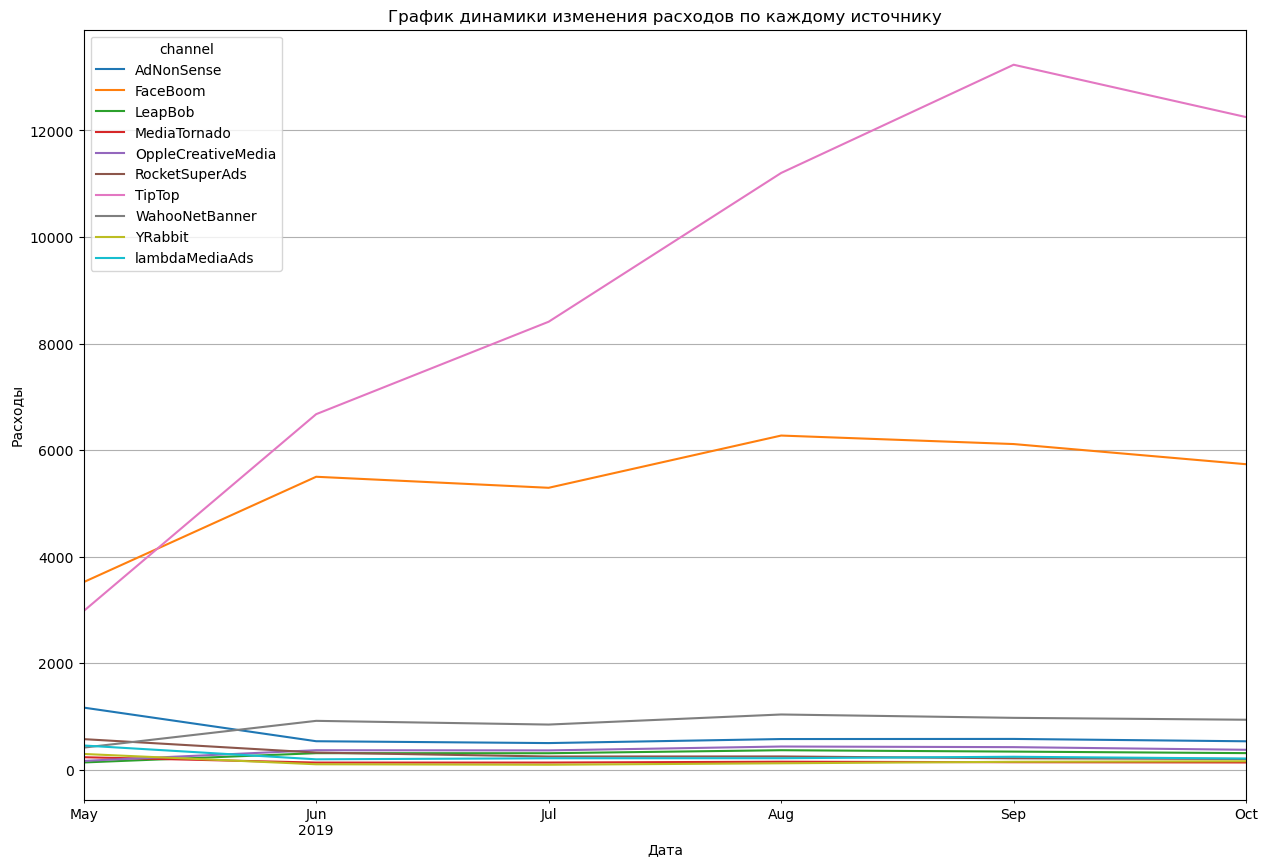

In [81]:
filtered_data = costs.pivot_table(
        index=costs['dt'].dt.to_period('M').dt.to_timestamp(), columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(15, 10),
           grid=True,
           legend = True
)

plt.title('График динамики изменения расходов по каждому источнику')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

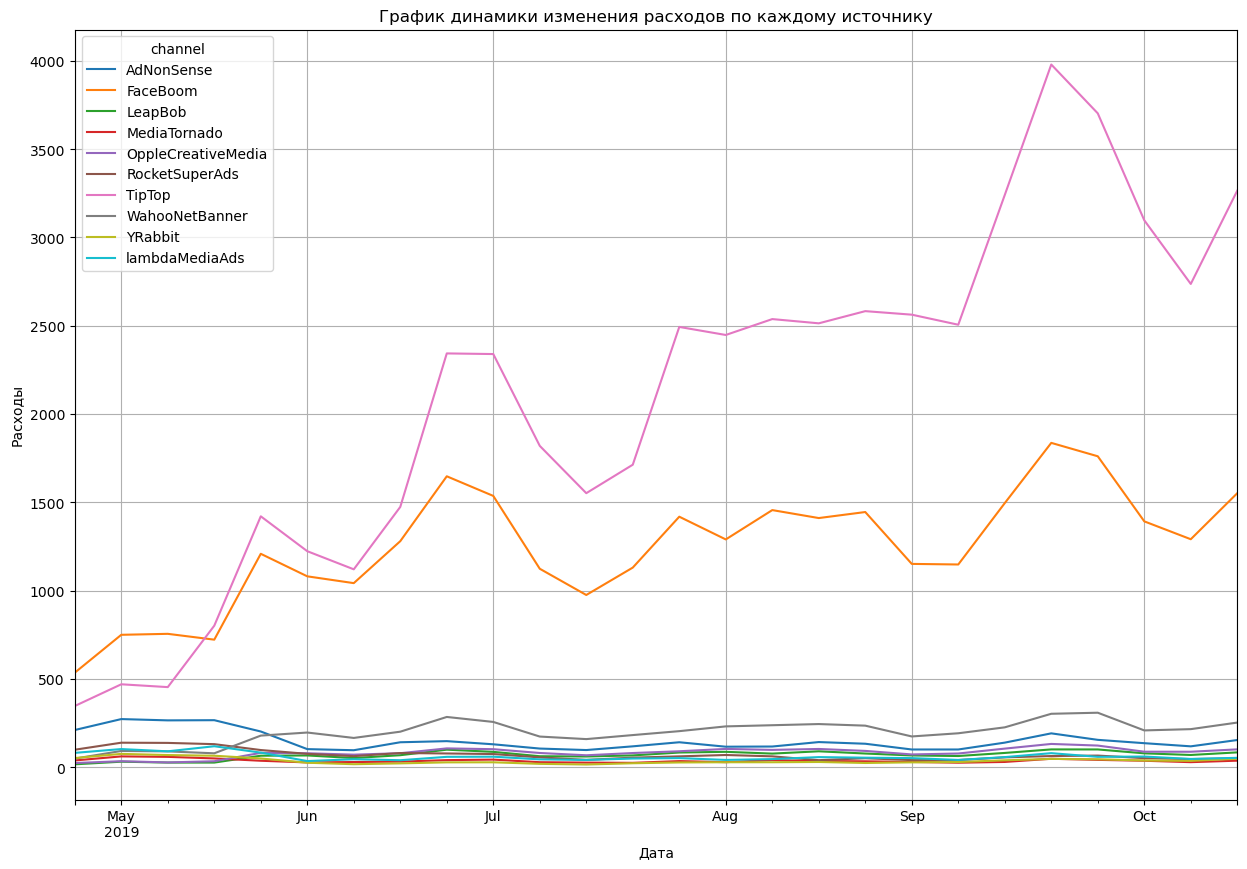

In [82]:
filtered_data = costs.pivot_table(
        index=costs['dt'].dt.to_period('W').dt.to_timestamp(), columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(15, 10),
           grid=True,
           legend = True
)

plt.title('График динамики изменения расходов по каждому источнику')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

Согласно полученному графику, TipTop и FaceBoom являются наиболее затратными каналами привлечения пользователей. На представленном промежутке времени у канала TipTop наблюдается только рост затрат. Остальные источники привлечения не показывают активной динамики на продолжении срока анализа и обходятся довольно-таки дешево. 

#### Средняя стоимость привлечения одного пользователя (САС) из каждого источника 

In [85]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [86]:
#для расчета средней стоимости привлечения одного пользователя исключим органический путь привлечения пользователей
cac_by_channel = pd.DataFrame()
profiles = profiles.query('channel != "organic"')
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самые "дорогие" пользователи приходят от канала TipTop, средняя стоимость пользователя составляет 2.8 у.е., что не удивительно, ведь он занимает первое место по количеству расходов. Далее примерно на одной месте располагаются каналы FaceBoom (1.11 у.е.) и AdNonSense (1.01 у.е.).

#### Промежуточные выводы
На маркетинг было потрачено 105497.3 у.е. Наиболее затратными каналами привлечения оказались TipTop, на него было потрачено 54751.30 у.е. и канал FaceBoom, затраты на который составили 32445.60 у.е. Однако, в отличие от канала FaceBoom, у канала TipTop наблюдается стабильный рост расходов в период с мая по ноябрь. Также с канала TipTop приходят самые "дорогие" пользователи, стоимость которых составляет 2.8 у.е.  
Вероятнее стоит уделить внимание каналам с более дешевой стоимостью привлечения. 

## Оценка окупаемости рекламы

#### Анализ окупаемости рекламы с помощью графиков LTV и ROI, графики динамики LTV, CAC, ROI

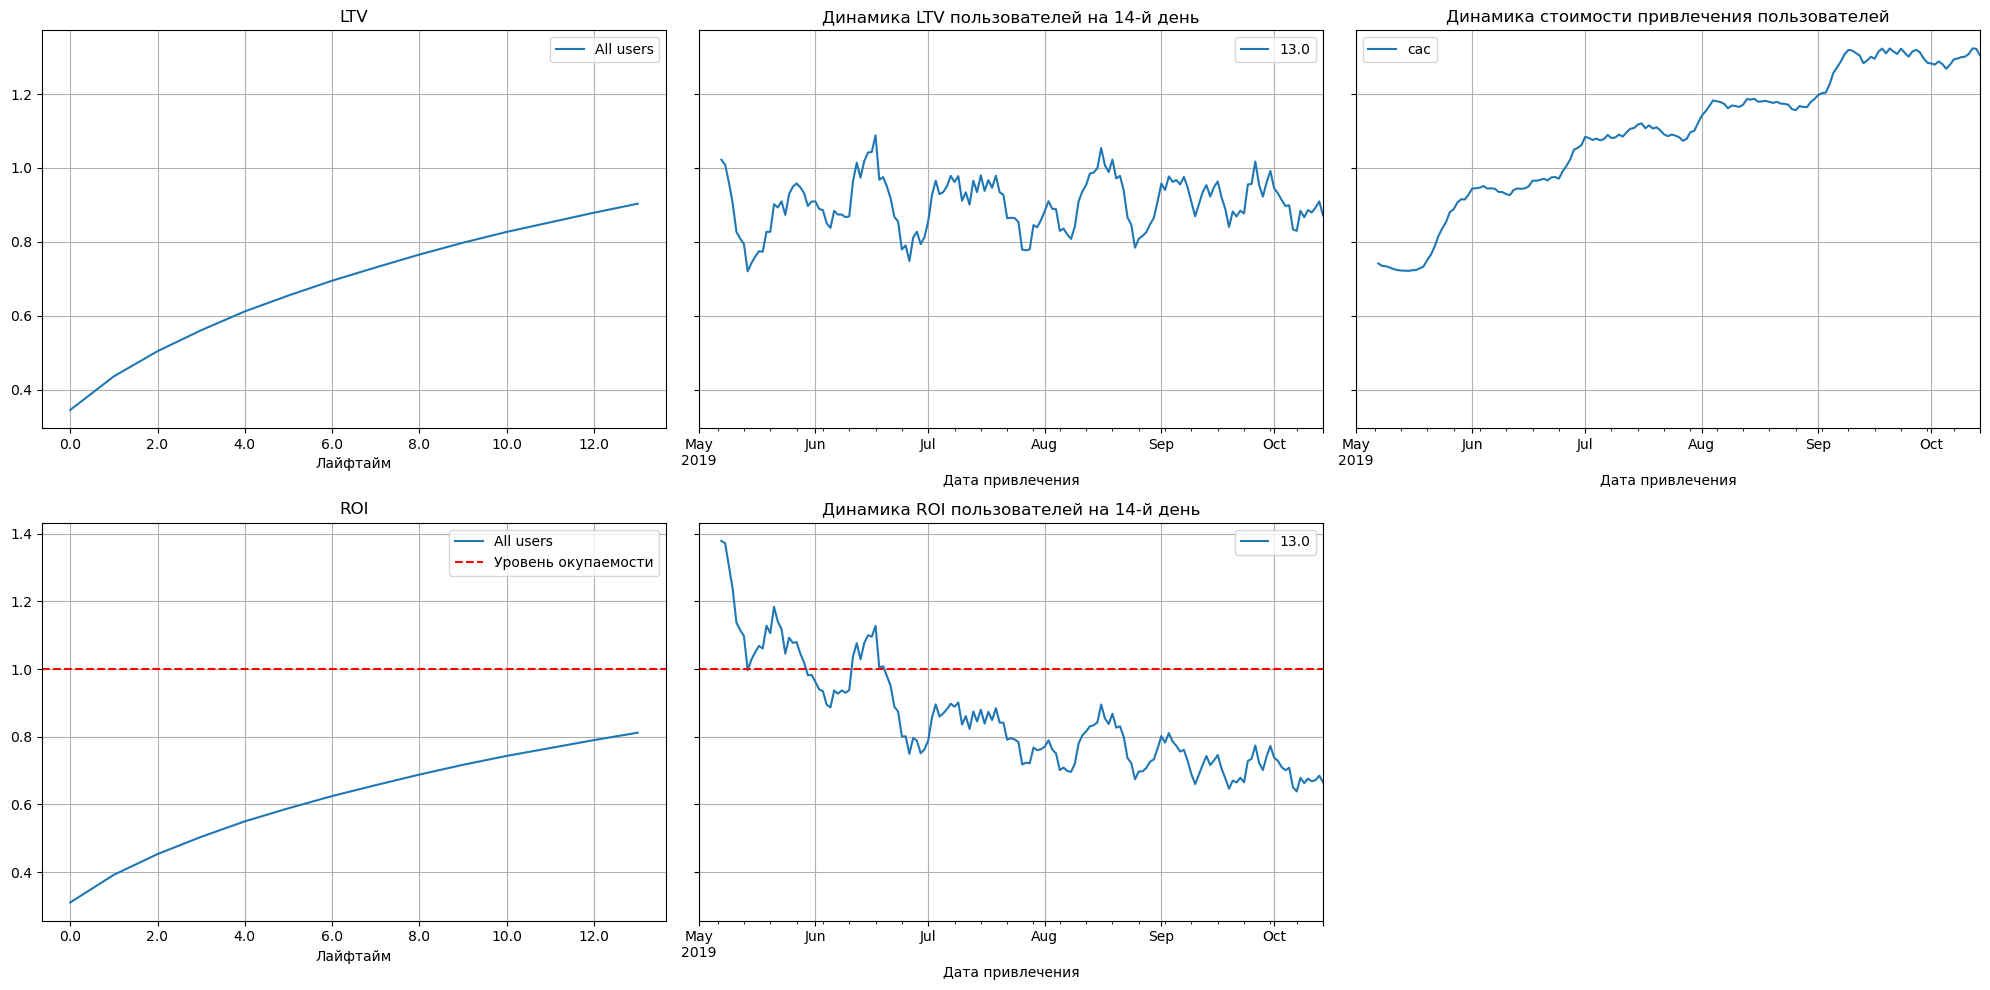

In [91]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Выводы по графикам:
1. Реклама не окупается, к концу второй недели ROI чуть выше 80%.
2. CAC нестабилен, рекламный бюджет некоторых каналов увеличивался со временем.
3. На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
4. Показаатель ROI стал в июне падать, с тех пор окупаемости так и не было. Нужно выявить причину. 

#### Динамика изменения конверсии и удержания пользователей 

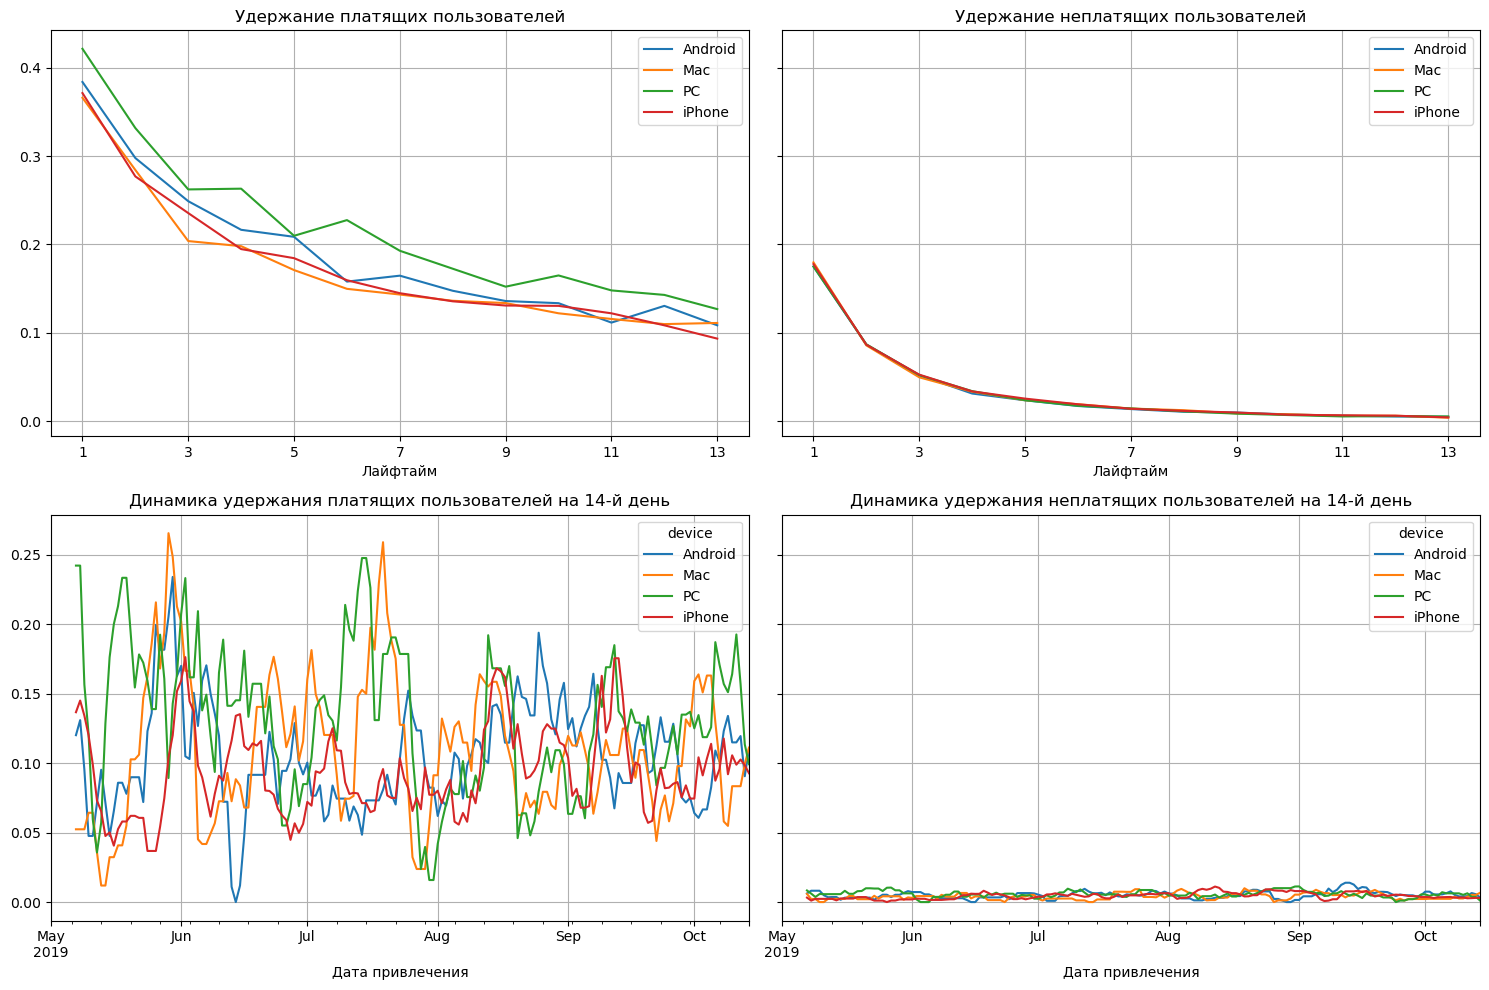

In [94]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 


Лучше всего удерживаются пользователи PC, хуже пользователи iPhone и Mac. 

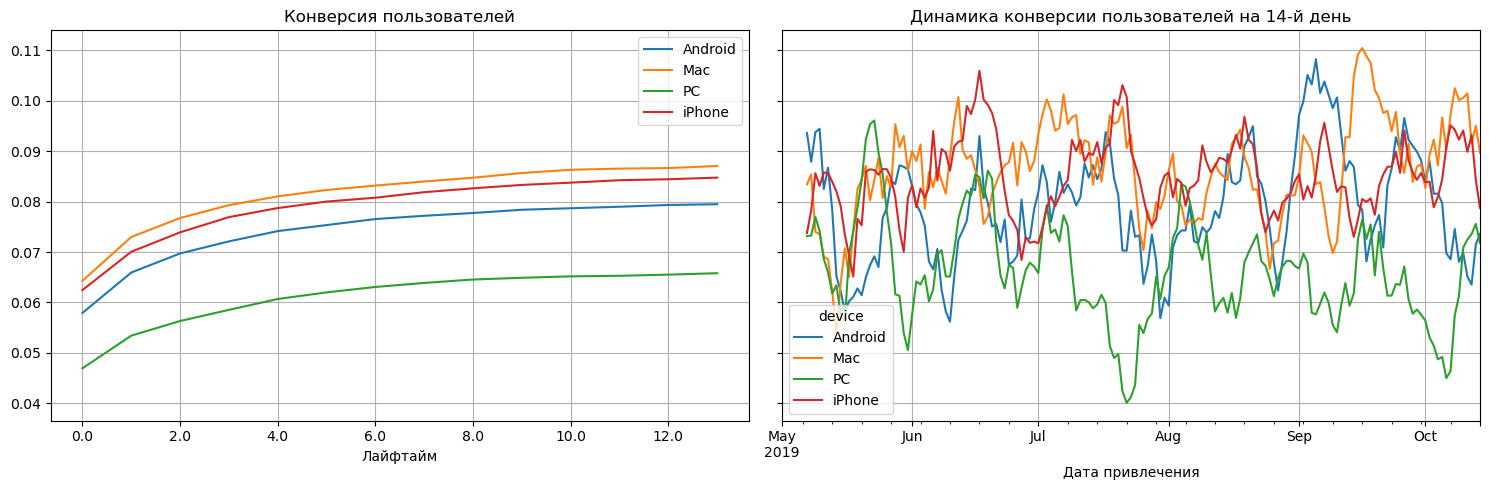

In [96]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи Mac, iPhone и Android конвертируются лучше всего, хуже пользователи PC. 

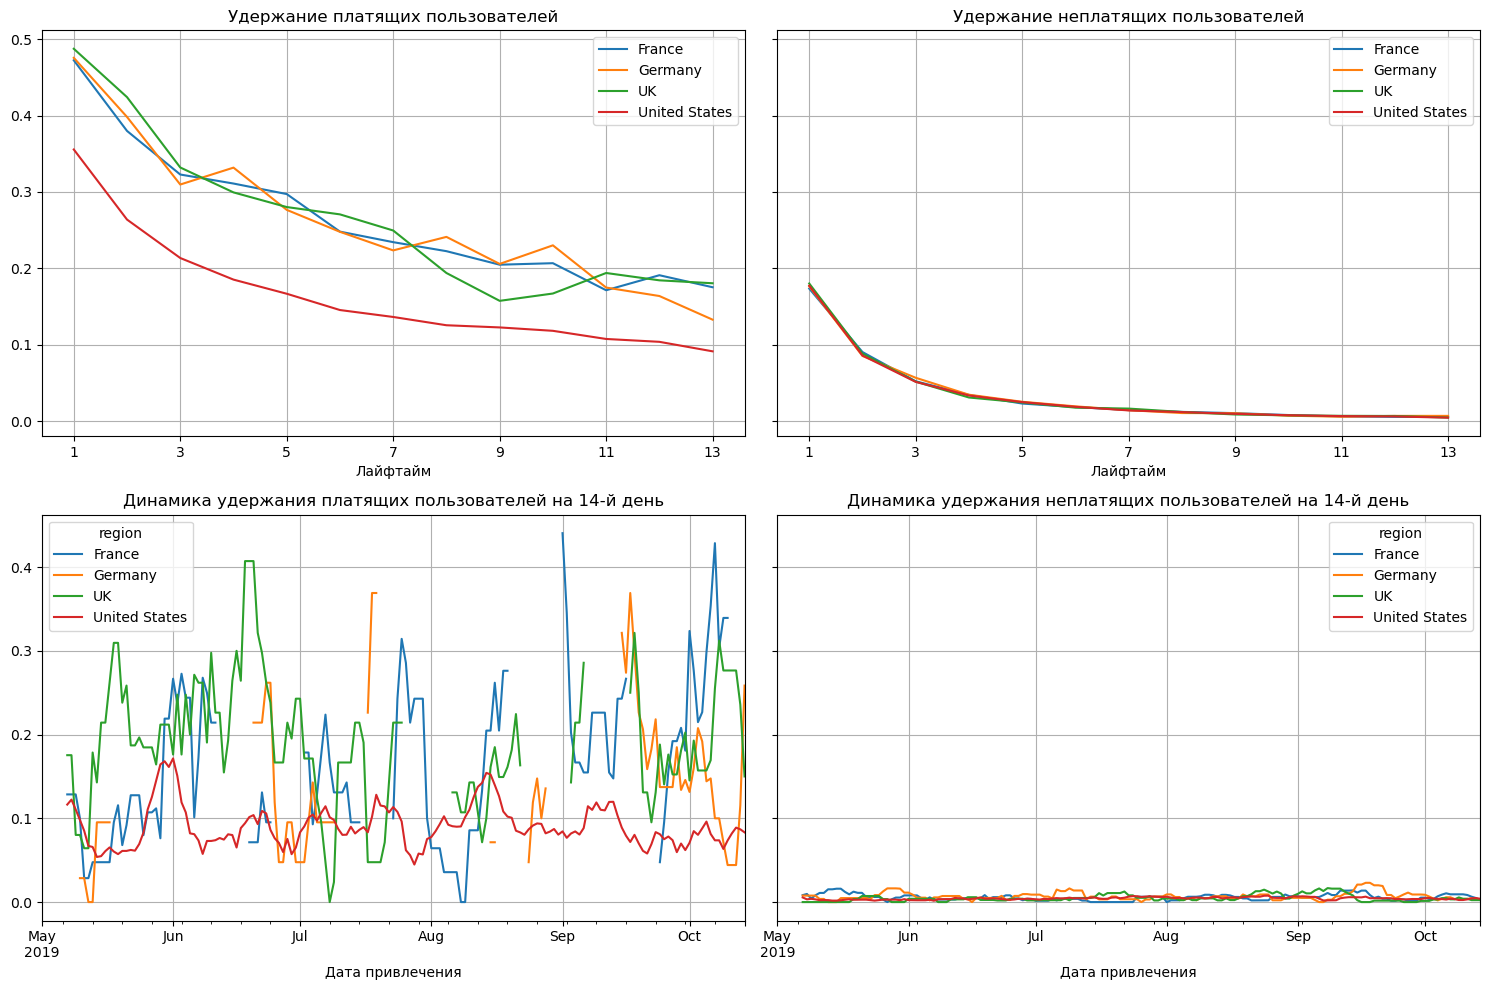

In [98]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Лучше всего удерживаются пользователи из Франции, Великобритании и Германи. Хуже всего из США. 

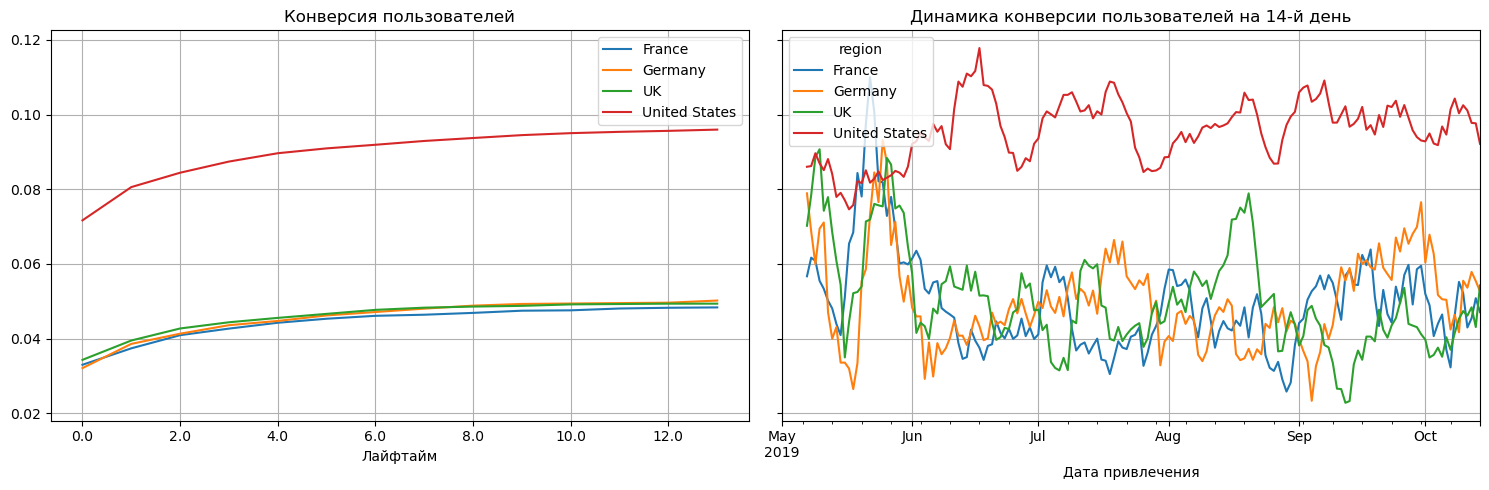

In [100]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи из США, хуже из Германии, Франции и Великобритании. 

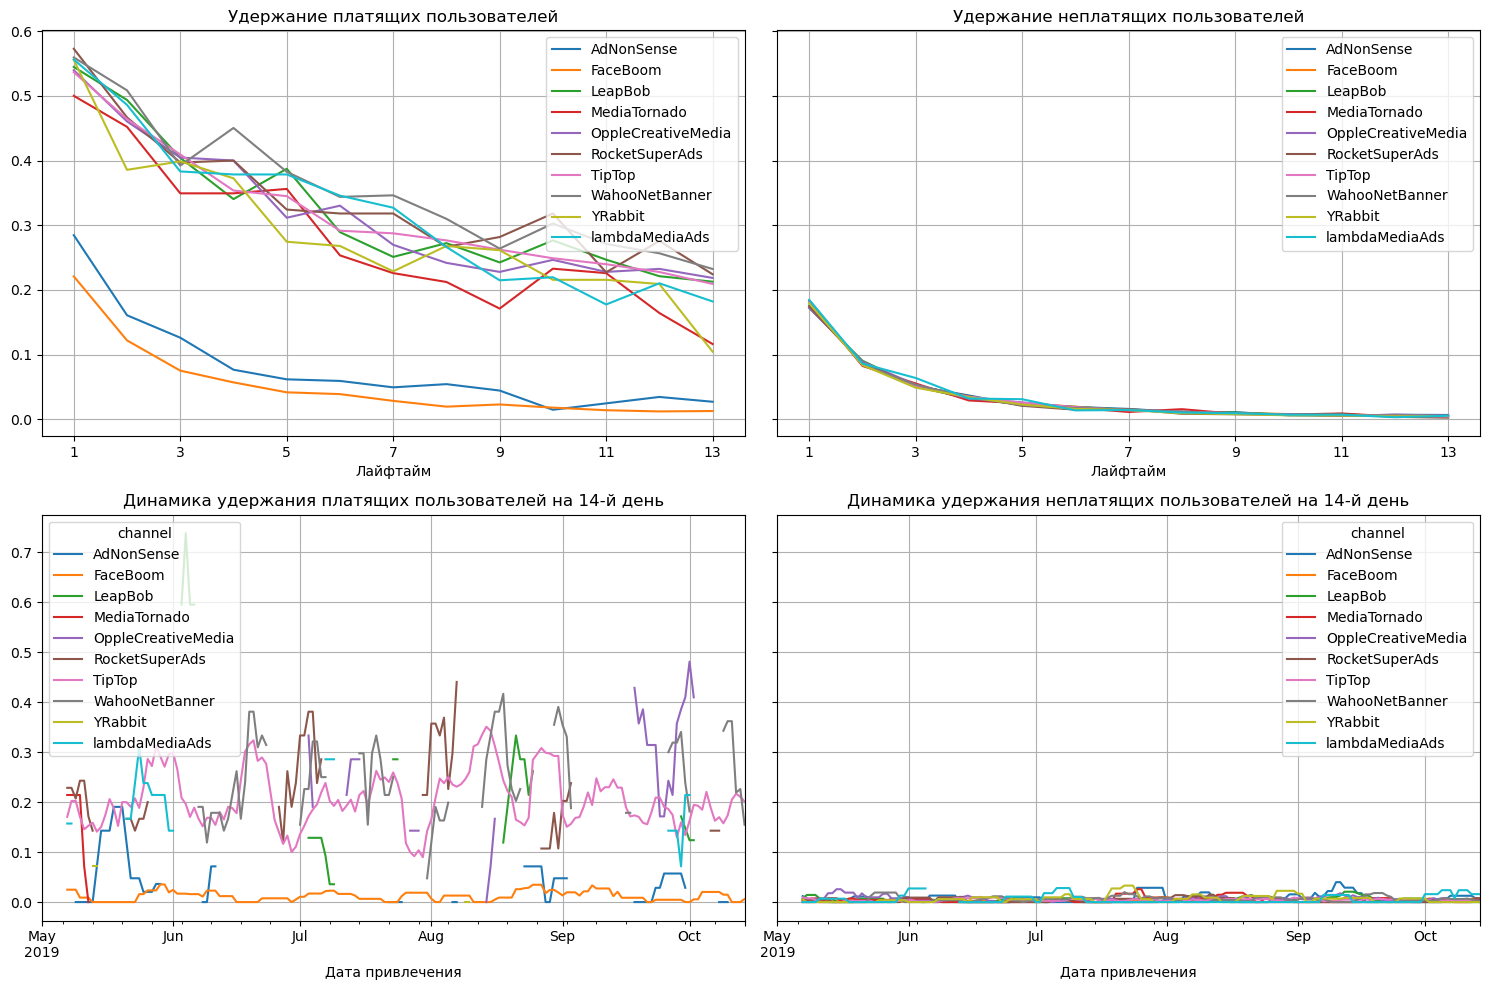

In [102]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Хуже всего удерживаются пользователи FaceBoom и AdNonSense. 

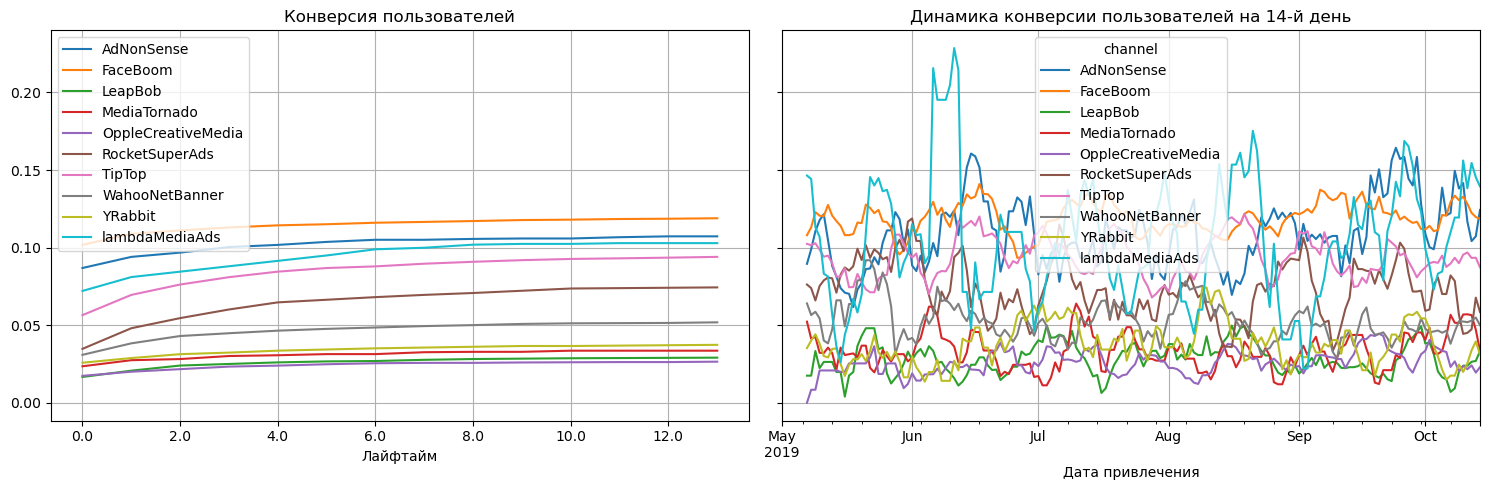

In [104]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи, привлеченные каналом FaceBoom. Хуже всего каналов OppleCreativeMedia, LeapBob, MediaTornado. 

#### Окупаемость рекламы с разбивкой по устройствам 

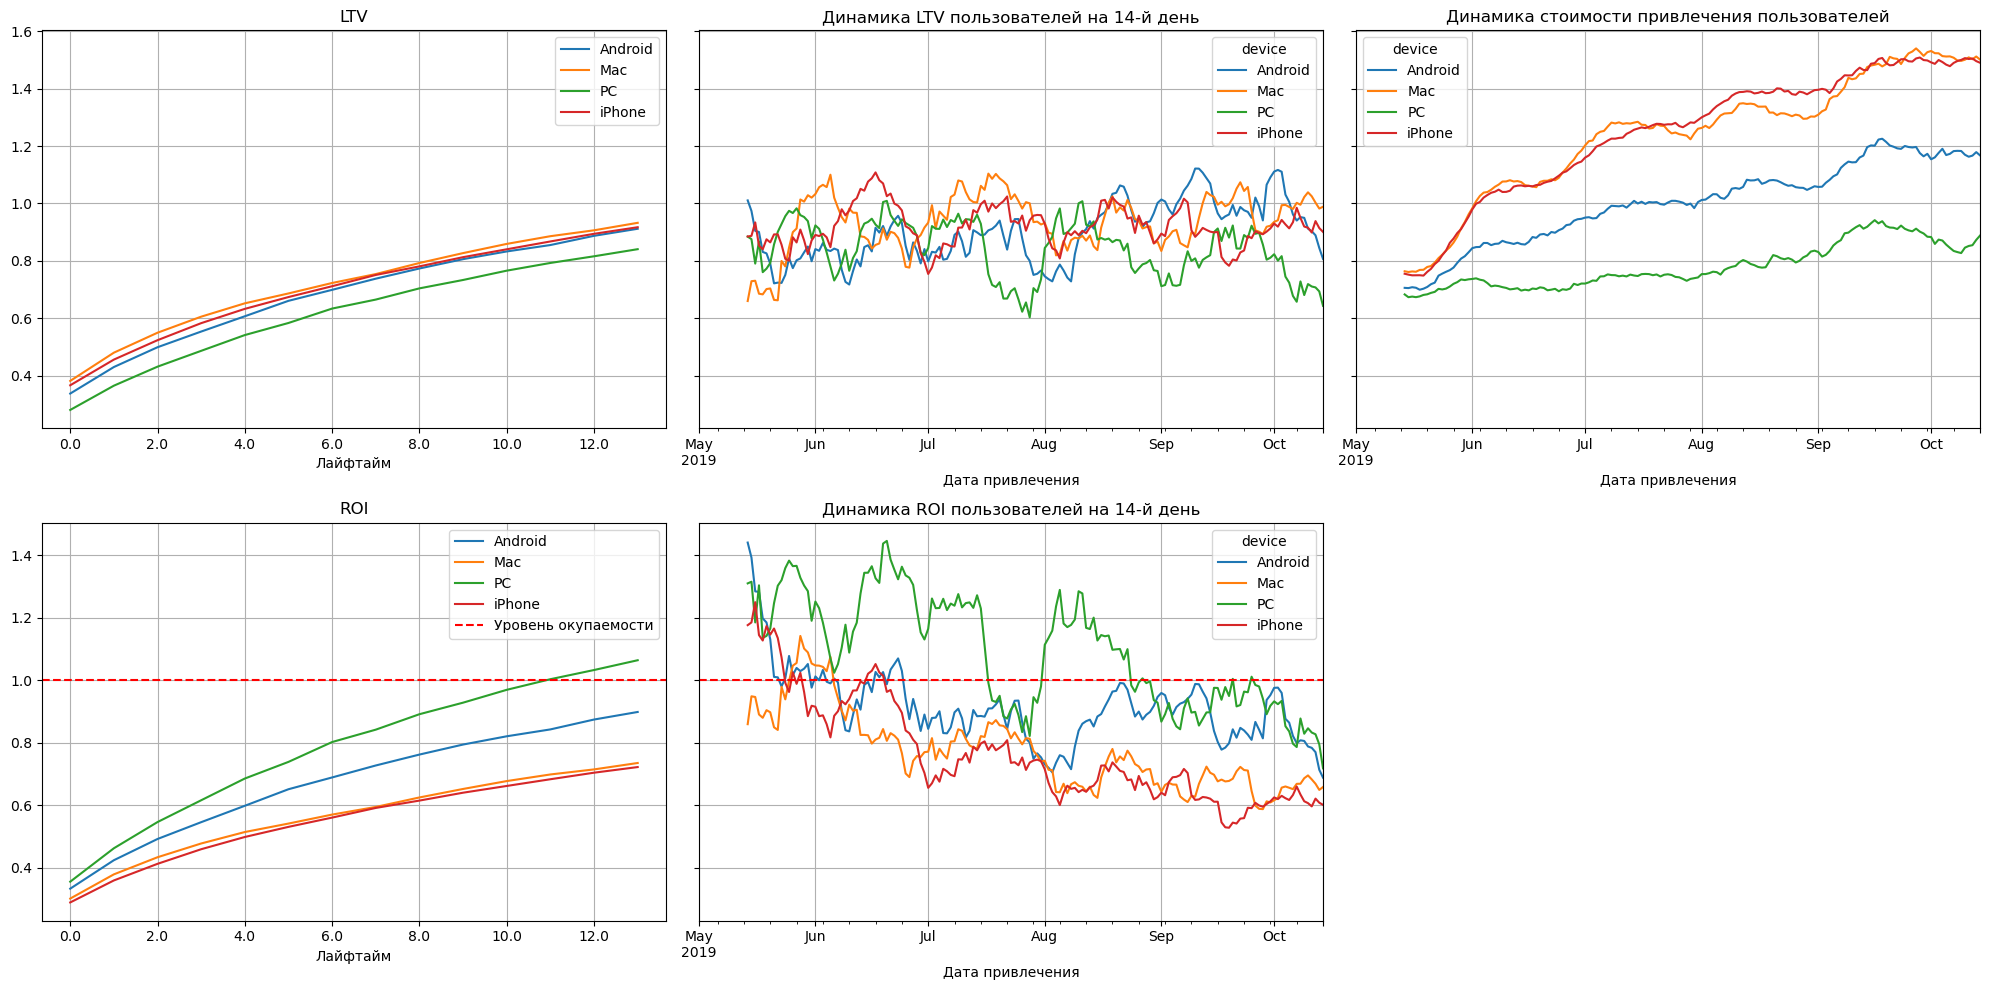

In [107]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выводы по графикам: 
Видим, что до июня окупались практически все пользователи, однако в июне резко пошла на спад окупаемость пользователей iPhone, Mac, и больше не возрастала. Колебался показатель окупаемости у пользователей Android на протяжении всего времени, но так и не стал больше окупаться. Не смотря на то, что окупаемость этих групп пользователей не происходила, наблюдаем стабильный рост стоимости привлечения пользователей на всем промежутке времени. LTV стабилен. 
Нужно выяснить проблему пользователей iPhone и Mac. 


#### Окупаемость рекламы с разбивкой по странам

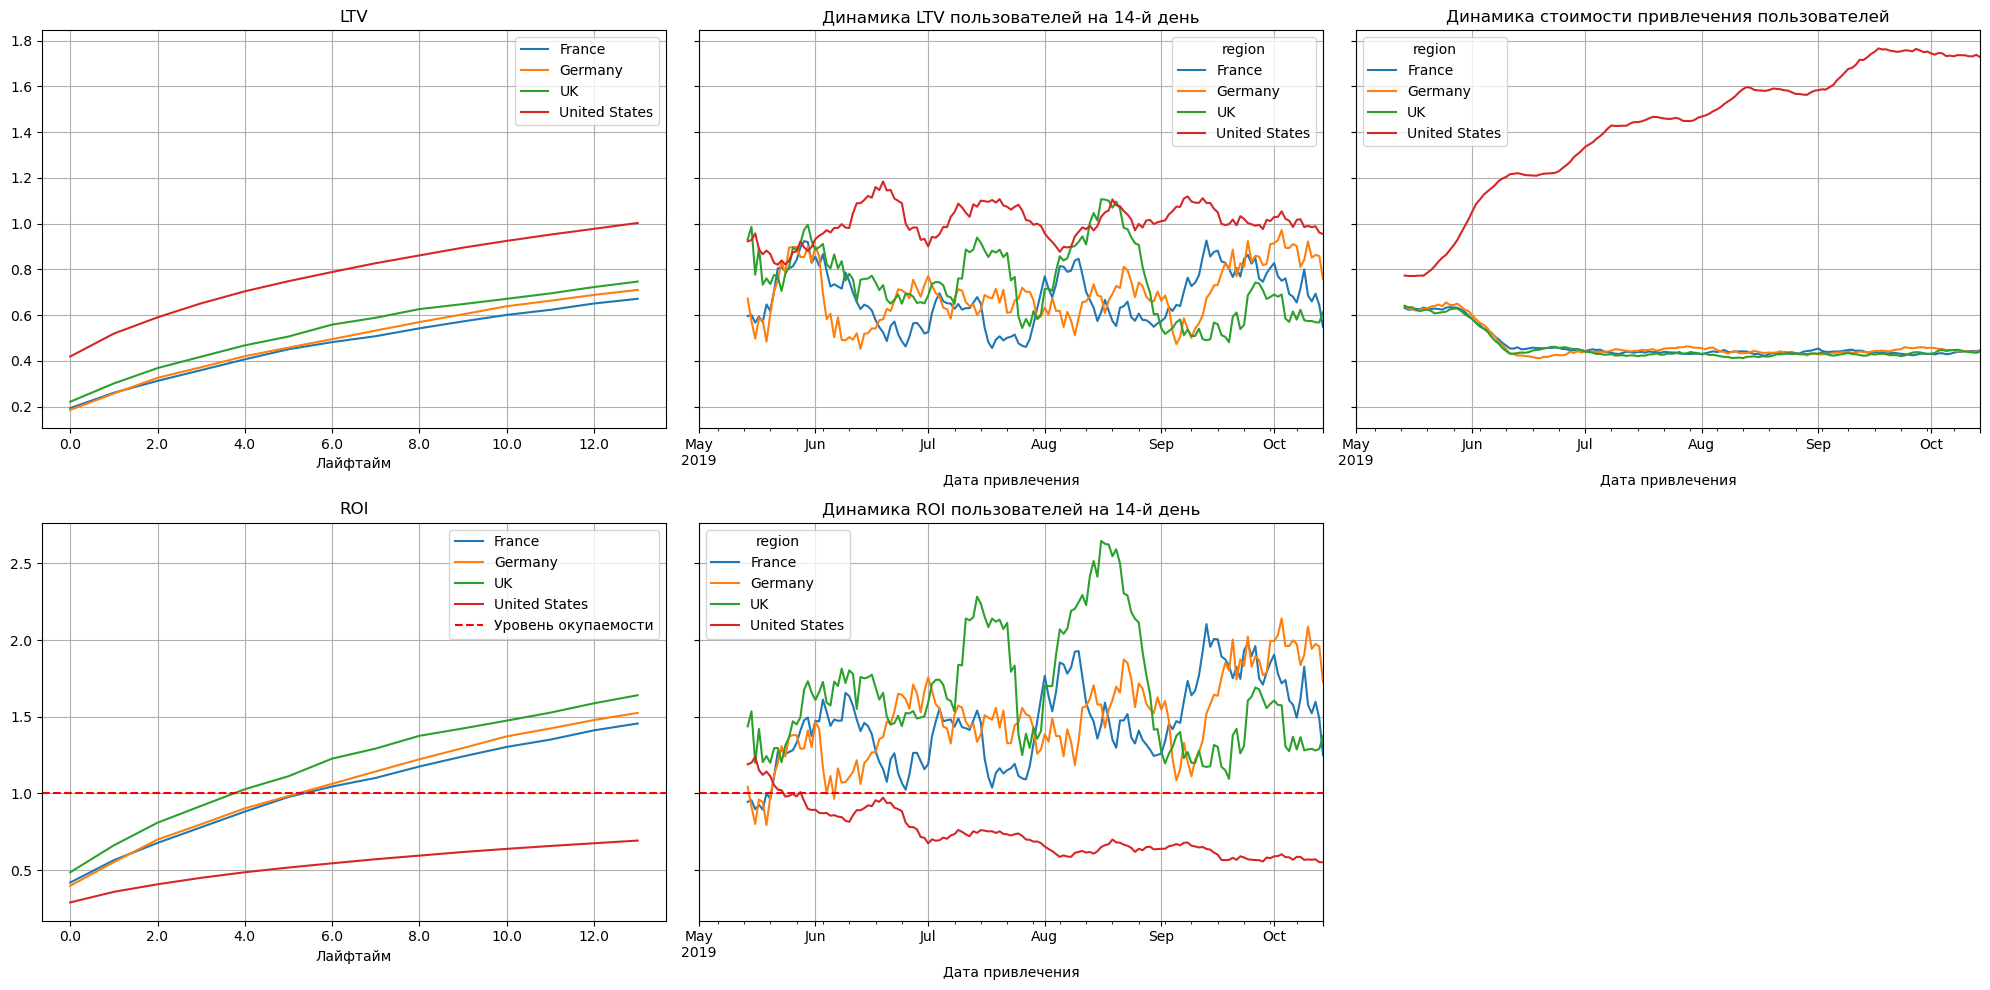

In [110]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выводы по графикам: Наблюдаем окупаемость во всех странах кроме США, согласно графику динамики уровень окупаемости в США только падал с мая по ноябрь. При этом мы имеем рост стоимости привлечения пользователей по США, который продолжается на всем периоде. Самую высокую окупаемость имеют пользователи из Великобритании. 

#### Окупаемость рекламы с разбивкой по рекламным каналам 

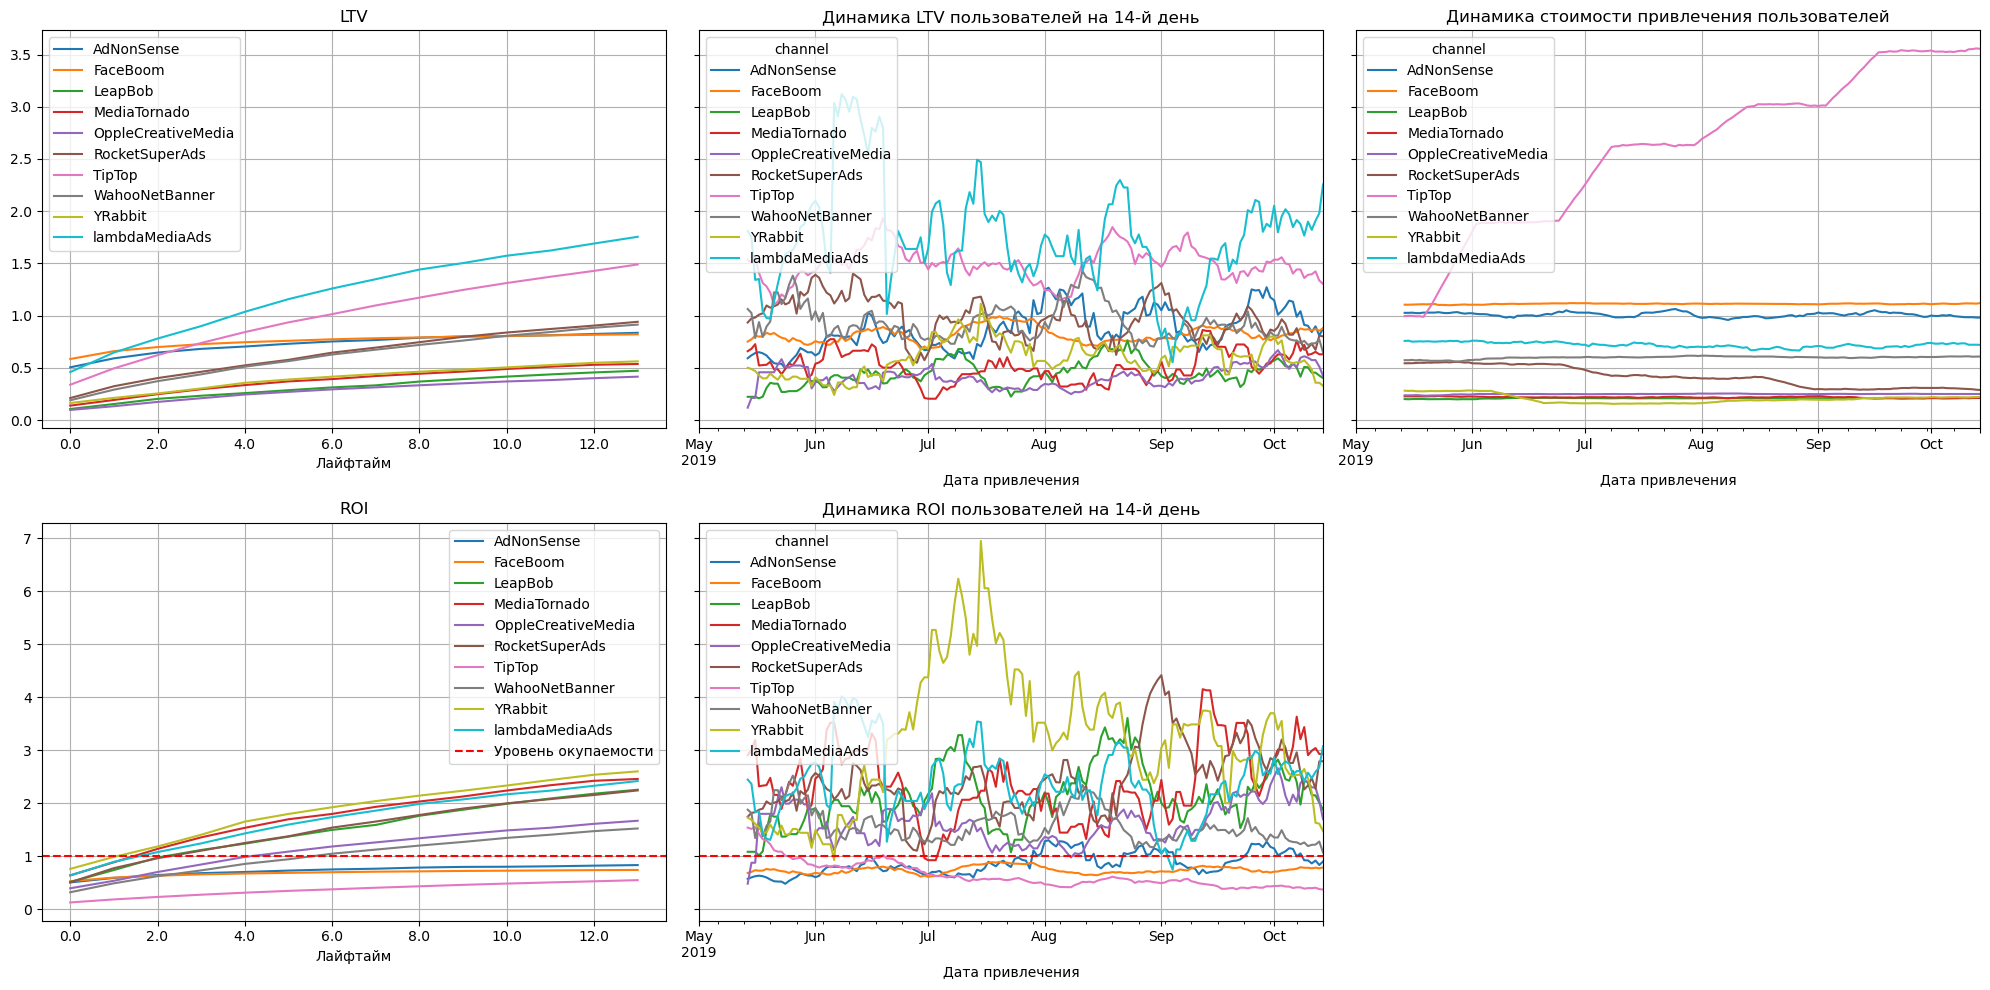

In [113]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выводы по графикам: У пользователей, привлеченных из каналов AdNonSense, FaceBoom и TipTop, совсем отсутствует окупаемость. Притом стоимость привлечения пользователей канала TipTop растет на протяжении всего времени, остальные каналы сохраняют стабильную стоимость. Хорошо окупается канал YRabbit, возможно ему стоит уделить больше внимания. LTV стабилен.  

#### Общий вывод оценки окупаемости рекламы
1. В целом на горизонте анализа реклама не окупается, одновременно с этим растут затраты на привлечение пользователей. 
2. Негативное влияние на окупаемость оказывают пользователи с устрайствами iPhone и MAC, проживающие в США, привлеченные каналами TipTop, FaceBoom и AdNonSense. При этом стоимость привлечения пользователей каналом TipTop только растет. 
3. Проблемы окупаемости могут вызваны некорректным выбором наиболее спонсируемого канала TipTop, который не дает нужный результат и привлекает пользователей из США с самым низким уровнем удержанием. Следует уделить внимание кааналам с более высокой окупаемостью. 

## Выводы

Было провдено исследование компании, владеющей приложением Procrastinate Pro+, которая с недавних пор начала терпеть убытки. В исследовании приняли участие жители Великобритании, Франции, Германии и США, притом большую часть, а именно 66%, составляют жители США. Также жители США составляют большую долю платежноспособных пользователей 6.9%. MAC занимает первое место по типу устройств, используемых платежноспособными пользователями %. Больше всего ресурсов расходуется на каналы TipTop (54751.30 у.е.) и FaceBoom (32445.60 у.е.). Согласно графику динамики расходов, у канала TipTop наблюдается активный рост на всем временном промежутке. Одновременно в этим канал TipTop имеет самую высокую среднюю стоимость привлечения одного клиента, она составляет 2.80 у.е. У канала FaceBoom средняя стоимость равняется 1.11 у.е. 
Было проведено исследование окупаемости рекламы, то есть были построены графики LTV и ROI, а также графики динамики LTV, CAC, ROI, которые показали, что реклама не окупается. ROI к коцну второй недели едва превышает отметку 0.8, возможно на более длительном горизонте анализа будет окупаемость. LTV стабилен, на него влияет сезонный фактор, значит дело не в ухудшении качества пользователей. CAC нестабилен, стоимость привлечения пользователей увеличивается на всем горизонте времени. Для того, чтобы понять причину посмотрим на окупаемость рекламы с разбивкой по типу устройства, стране и каналу привлечения. 
Разбивка по типу устройств. LTV стабилен. Хорошо показывают себя пользователи PC: они имеют самую низкую стоимость привлечения и самый высокий уровень окупаемости. Пользователи всех остальных устройств не окупаются. Были построены визуализации удержания и конверсии пользователей. Самое высокое удержание имеют платежноспособные пользователи PC, чуть хуже удерживаются пользователи iPhone и MAC. Однако, пользователи PC конвертируются хуже остальных. 
Разбивка по странам. LTV стабильный. Пользоатели из США имеют самую высокую стоимость привлечения, которая растет на всем промежутке времени, однако пользователи из США не окупаются от слова совсем, в отличие от пользователей из других стран. При этом пользователи из США составляют большую часть пользователей приложения 77.72%. Лучше всего конвертируются пользователи из США, а удерживаются чуть хуже пользователей из других стран. 
Разбивка по каналам привлечения. LTV стабильный. Самый популярный канал TipTop имеет постоянный рост стоимости привлечения пользователей, но при этом не окупается. Также не окупаются пользователи из каналов AdNonSense, FaceBoom (является вторым по расходам на рекламу) и имеют самое низкое удержание. 